In [10]:
import math
import sys
import numpy as np
import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers
import paddle.fluid.nets as nets
import os
import matplotlib.pyplot as plt

In [2]:
movie_info = paddle.dataset.movielens.movie_info()
print(type(movie_info))
print(movie_info[1])
print(type(movie_info[1]))
print(movie_info[1].value())  # title 和 category 都被处理成了序列形式
print(movie_info[2])
print(movie_info[2].value())

<class 'dict'>
<MovieInfo id(1), title(Toy Story ), categories(['Animation', "Children's", 'Comedy'])>
<class 'paddle.dataset.movielens.MovieInfo'>
[1, [15, 6, 17], [4685, 348]]
<MovieInfo id(2), title(Jumanji ), categories(['Adventure', "Children's", 'Fantasy'])>
[2, [4, 6, 13], [2348]]


In [3]:
user_info = paddle.dataset.movielens.user_info()
print(type(user_info))
print(user_info[1])
print(type(user_info[1]))
print(user_info[1].value())

<class 'dict'>
<UserInfo id(1), gender(F), age(1), job(10)>
<class 'paddle.dataset.movielens.UserInfo'>
[1, 1, 0, 10]


In [4]:
# 打印某条训练数据
train_set_creator = paddle.dataset.movielens.train()
print(type(train_set_creator))
train_sample = next(train_set_creator())
print(type(train_sample))
print(train_sample)
uid = train_sample[0]
mov_id = train_sample[len(user_info[uid].value())]
print("User %s rates Movie %s with Score %s"%(user_info[uid], movie_info[mov_id], train_sample[-1]))

<class 'function'>
<class 'list'>
[1, 1, 0, 10, 1193, [8], [2954, 349, 4624, 1921, 792, 639], [5.0]]
User <UserInfo id(1), gender(F), age(1), job(10)> rates Movie <MovieInfo id(1193), title(One Flew Over the Cuckoo's Nest ), categories(['Drama'])> with Score [5.0]


In [5]:
IS_SPARSE = True
USE_GPU = False
BATCH_SIZE = 256

In [6]:
uid = layers.data(name='user_id', shape=[1], dtype='int64')
usr_gender_id = layers.data(name='gender_id', shape=[1], dtype='int64')
usr_age_id = layers.data(name='age_id', shape=[1], dtype="int64")
usr_job_id = layers.data(name='job_id', shape=[1], dtype="int64")
mov_id = layers.data(name='movie_id', shape=[1], dtype='int64')
category_id = layers.data(
    name='category_id', shape=[1], dtype='int64', lod_level=1)
mov_title_id = layers.data(
        name='movie_title', shape=[1], dtype='int64', lod_level=1)
label = layers.data(name='score', shape=[1], dtype='float32')

In [7]:
def get_usr_combined_features():
    
    global uid, usr_gender_id, usr_age_id, usr_job_id
    
    USR_DICT_SIZE = paddle.dataset.movielens.max_user_id() + 1
    usr_emb = layers.embedding(
        input=uid,
        dtype='float32',
        size=[USR_DICT_SIZE, 32],
        param_attr='user_table',
        is_sparse=IS_SPARSE)
    usr_fc = layers.fc(input=usr_emb, size=32)
    
    USR_GENDER_DICT_SIZE = 2
    usr_gender_emb = layers.embedding(
        input=usr_gender_id,
        size=[USR_GENDER_DICT_SIZE, 16],
        param_attr='gender_table',
        is_sparse=IS_SPARSE)
    usr_gender_fc = layers.fc(input=usr_gender_emb, size=16)
    
    USR_AGE_DICT_SIZE = len(paddle.dataset.movielens.age_table)
    usr_age_emb = layers.embedding(
        input=usr_age_id,
        size=[USR_AGE_DICT_SIZE, 16],
        is_sparse=IS_SPARSE,
        param_attr='age_table')
    usr_age_fc = layers.fc(input=usr_age_emb, size=16)
    
    USR_JOB_DICT_SIZE = paddle.dataset.movielens.max_job_id() + 1
    usr_job_emb = layers.embedding(
        input=usr_job_id,
        size=[USR_JOB_DICT_SIZE, 16],
        param_attr='job_table',
        is_sparse=IS_SPARSE)
    usr_job_fc = layers.fc(input=usr_job_emb, size=16)
    
    concat_embed = layers.concat(
        input=[usr_fc, usr_gender_fc, usr_age_fc, usr_job_fc],
        axis=1)
    
    usr_combined_features = layers.fc(input=concat_embed, size=200, act="tanh")
    
    return usr_combined_features

In [8]:
def get_mov_combined_features():

    global mov_id, category_id, mov_title_id
    
    MOV_DICT_SIZE = paddle.dataset.movielens.max_movie_id() + 1
    mov_emb = layers.embedding(
        input=mov_id,
        dtype='float32',
        size=[MOV_DICT_SIZE, 32],
        param_attr='movie_table',
        is_sparse=IS_SPARSE)
    mov_fc = layers.fc(input=mov_emb, size=32)

    CATEGORY_DICT_SIZE = len(paddle.dataset.movielens.movie_categories())
    mov_categories_emb = layers.embedding(
        input=category_id, size=[CATEGORY_DICT_SIZE, 32], is_sparse=IS_SPARSE)
    mov_categories_hidden = layers.sequence_pool(
        input=mov_categories_emb, pool_type="sum")
    
    MOV_TITLE_DICT_SIZE = len(paddle.dataset.movielens.get_movie_title_dict())    
    mov_title_emb = layers.embedding(
        input=mov_title_id, size=[MOV_TITLE_DICT_SIZE, 32], is_sparse=IS_SPARSE)
    mov_title_conv = nets.sequence_conv_pool(
        input=mov_title_emb,
        num_filters=32,
        filter_size=3,
        act="tanh",
        pool_type="sum")
    
    concat_embed = layers.concat(
        input=[mov_fc, mov_categories_hidden, mov_title_conv], 
        axis=1)
    
    mov_combined_features = layers.fc(input=concat_embed, size=200, act="tanh")

    return mov_combined_features

In [9]:
def inference_program():
    # 用户向量
    usr_combined_features = get_usr_combined_features()
    # 电影向量
    mov_combined_features = get_mov_combined_features()
    # 余弦相似度
    inference = layers.cos_sim(X=usr_combined_features, Y=mov_combined_features)
    # 缩放到 0 ~ 5 之间
    scale_infer = layers.scale(x=inference, scale=5.0) 
    return scale_infer

scale_infer = inference_program()
square_cost = layers.square_error_cost(input=scale_infer, label=label)
avg_cost = layers.mean(square_cost)
optimizer = fluid.optimizer.SGD(learning_rate=0.2) 
opts = optimizer.minimize(avg_cost)

Pass:0, Batch:0, Cost:9.67275
Pass:0, Batch:200, Cost:3.52813
Pass:0, Batch:400, Cost:4.78923
Pass:0, Batch:600, Cost:4.76602
Pass:0, Batch:800, Cost:4.27736
Pass:0, Batch:1000, Cost:3.63871
Pass:0, Batch:1200, Cost:4.19438
Pass:0, Batch:1400, Cost:3.49573
Pass:0, Batch:1600, Cost:4.52994
Pass:0, Batch:1800, Cost:3.39870
Pass:0, Batch:2000, Cost:3.76183
Pass:0, Batch:2200, Cost:2.94742
Pass:0, Batch:2400, Cost:3.30220
Pass:0, Batch:2600, Cost:2.76413
Pass:0, Batch:2800, Cost:3.67986
Pass:0, Batch:3000, Cost:2.66672
Pass:0, Batch:3200, Cost:3.70654
Pass:0, Batch:3400, Cost:3.09849
Test:0, Cost:3.45486
Pass:1, Batch:0, Cost:3.37104
Pass:1, Batch:200, Cost:2.82102
Pass:1, Batch:400, Cost:3.02343
Pass:1, Batch:600, Cost:3.81838
Pass:1, Batch:800, Cost:3.25057
Pass:1, Batch:1000, Cost:2.72824
Pass:1, Batch:1200, Cost:3.19903
Pass:1, Batch:1400, Cost:3.41268
Pass:1, Batch:1600, Cost:3.29644
Pass:1, Batch:1800, Cost:4.20925
Pass:1, Batch:2000, Cost:4.18217
Pass:1, Batch:2200, Cost:2.99929
Pas

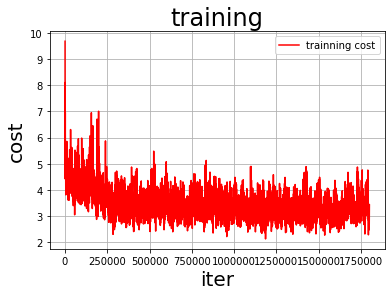

In [11]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,label_cost):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.legend()
    plt.grid()
    plt.show()

# 准备数据
train_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.movielens.train(), buf_size=8192),
    batch_size=BATCH_SIZE)

test_reader = paddle.batch(
    paddle.dataset.movielens.test(), batch_size=BATCH_SIZE)

# 定义运算场所
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

test_program = fluid.default_main_program().clone(for_test=True)  # 获取测试程序
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

# 定义 DataFeeder
feeder = fluid.DataFeeder(place=place, feed_list=[uid, usr_gender_id, usr_age_id, usr_job_id,
                                                  mov_id, category_id, mov_title_id,
                                                  label])

# 训练
EPOCH_NUM=2
model_save_dir = "./model/recommender_system.inference.model"
for pass_id in range(EPOCH_NUM):
    for batch_id, data in enumerate(train_reader()):
        train_cost = exe.run(program=fluid.default_main_program(),  # 运行主程序
                            feed=feeder.feed(data),
                            fetch_list=[avg_cost])
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        # 每200个batch打印一次信息  误差、准确率
        if batch_id % 200 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f' % (pass_id, batch_id, train_cost[0]))
    # 进行测试
    test_costs = []
    #每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):
        test_cost = exe.run(program=test_program,
                            feed=feeder.feed(data),
                            fetch_list=[avg_cost])
        test_costs.append(test_cost[0])
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost))
# 画 loass 曲线图
draw_train_process("training",all_train_iters,all_train_costs,"trainning cost")

In [12]:
# 保存模型
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,  # 模型路径
                              # 推理时需要 feed 的数据，与模型输入 tensor 的 name 对应
                              ["user_id", "gender_id", "age_id", "job_id",
                               "movie_id", "category_id", "movie_title"],
                              [scale_infer], # 保存推理（inference）结果的 Variables
                              exe) # executor 保存 inference model
print('训练模型保存完成')

save models to ./model/recommender_system.inference.model
训练模型保存完成


In [13]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

# 加载数据并开始预测
with fluid.scope_guard(inference_scope):
    # inference_program: 推理 program
    # feed_target_names: 是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称
    # fetch_targets: 是一个 Variable 列表，从中我们可以得到推断结果
    # model_path: 模型路径
    # infer_exe: 运行 inference model 的 executor
    [inference_program,                                        
     feed_target_names,
     fetch_targets
    ] = fluid.io.load_inference_model(model_save_dir,
                                      infer_exe)
    # 构造数据用于推理
    infer_movie_id = 783
    infer_movie_name = paddle.dataset.movielens.movie_info()[infer_movie_id].title
    user_id = fluid.create_lod_tensor([[1]], [[1]], place)
    gender_id = fluid.create_lod_tensor([[1]], [[1]], place)
    age_id = fluid.create_lod_tensor([[0]], [[1]], place)
    job_id = fluid.create_lod_tensor([[10]], [[1]], place)
    movie_id = fluid.create_lod_tensor([[783]], [[1]], place) # Hunchback of Notre Dame
    category_id = fluid.create_lod_tensor([[10, 8, 9]], [[3]], place) # Animation, Children's, Musical
    movie_title = fluid.create_lod_tensor([[1069, 4140, 2923, 710, 988]], [[5]],
                                      place) # 'hunchback','of','notre','dame','the'
    # 执行 executor 的 run 方法，调用推理 program，feed 数据，返回结果
    results = infer_exe.run(
        program=inference_program,
        feed={feed_target_names[0]: user_id,
            feed_target_names[1]: gender_id,
            feed_target_names[2]: age_id,
            feed_target_names[3]: job_id,
            feed_target_names[4]: movie_id,
            feed_target_names[5]: category_id,
            feed_target_names[6]: movie_title},
        return_numpy=False,
        fetch_list=fetch_targets)
    print("="*60)
    print(results)
    print("="*60)
    print(type(results))
    print("="*60)
    print(results[0])
    print("="*60)
    print(np.array(results[0]))
    print("="*60)
    print("Predict Rating of user id 1 on movie \"" + infer_movie_name + "\" is " + str(results[0][0]))
    print("Actual Rating of user id 1 on movie \"" + infer_movie_name + "\" is 4.")

<class 'list'>
	lod: {{0, 1}}
	dim: 1, 1
	layout: NCHW
	dtype: float
	data: [2.53842]

[[2.538422]]
Predict Rating of user id 1 on movie "Hunchback of Notre Dame, The " is 	dim: 1, 1
	layout: NCHW
	dtype: float
	data: [2.53842]
Actual Rating of user id 1 on movie "Hunchback of Notre Dame, The " is 4.
